# Sección 2

## Pregunta 1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
df = pd.read_csv('/Users/Stefano_1/Downloads/challenge_data.csv')

Se empieza por revisar características de los datos como la variable objetivo, si existen missings y las interacciones entre todas las variables numéricas.

In [ ]:
# Se revisa la variable objetivo.
# En este caso se ve que es una muestra imbalanceada por lo que
# es necesario tomar esto en cuenta para modelar
sns.countplot(x='impago', data=df, palette='pastel')
plt.xlabel('Impago')
plt.ylabel('')
plt.gca().set_frame_on(True)
plt.legend().set_visible(False)
plt.show()

En el caso de missings, existen varias columnas con distinto número de missings, algunos se pueden asumir como ceros y otros habrá que elegir una estrategia de input. Datos como los porcentajes y pagos con missings sugieren que no existen estos datos para el cliente, por lo que se pueden pensar como 0 al no tener historial, por otro lado aquellos de crédito tendrán que seguir probablemente un SimpleImputer con la mediana para evitar sesgo por posibles outliers.

<ipython-input-117-6a60b0672f3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='column', y='count', data=na_count, palette=['blue']*len(na_count))


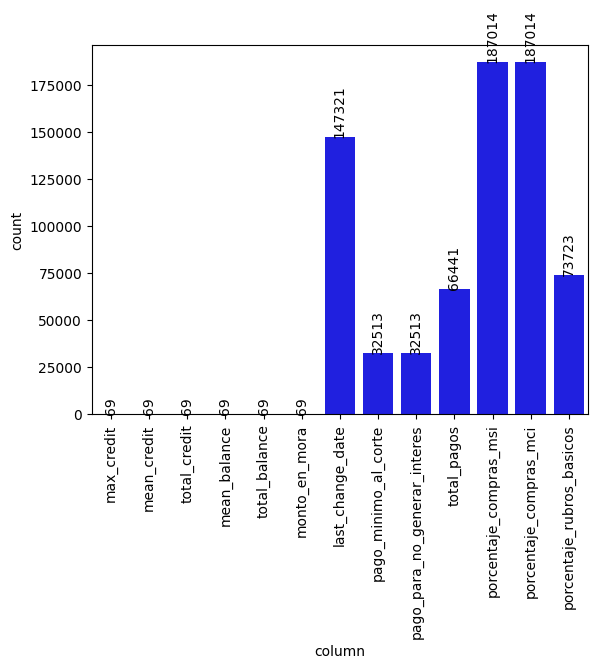

In [ ]:
# Revisar cuales columnas tienen nulls o missings en sus valores
# para considerar una estrategia de inputting
na_count = df.isna().sum()
na_count = na_count[na_count > 0].reset_index()
na_count.columns = ['column', 'count']

sns.barplot(x='column', y='count', data=na_count,
            palette=['blue']*len(na_count))
for index, row in na_count.iterrows():
    plt.text(index, row['count'], str(row['count']), color='black',
             ha="center", va="bottom", rotation = 90)
plt.xlabel('column')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.gca().set_frame_on(True)  # Equivalent to theme_bw()
plt.show()

La matriz de correlaciones muestra que pocas variables tienen correlaciones importantes, pero esto no significa que no tengan importancia para los modelos y muestra que todas pueden aportar información adicional al no estar altamente correlacionadas.

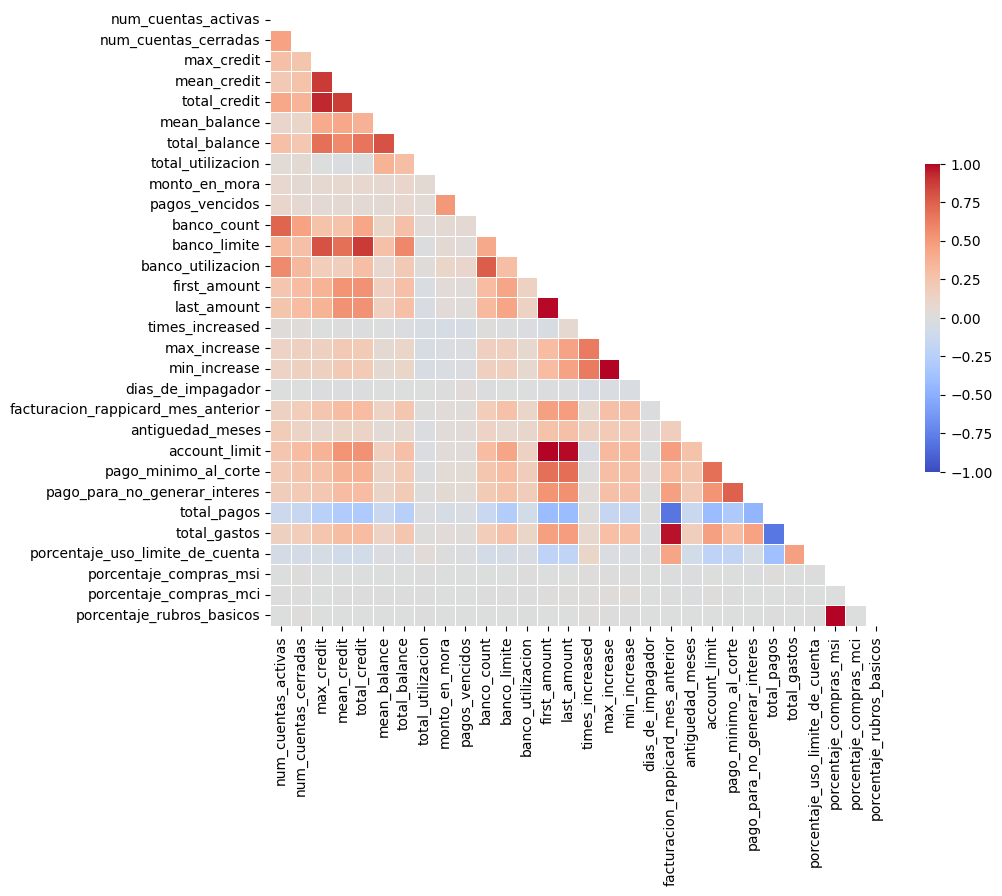

In [ ]:
# se excluyen columnas que no son numericas y se descartan null
cols = [col for col in df.columns if col not in ['id', 'last_change_date',
                                                 'impago']]

df_clean = df[cols].dropna()

#correlacion
corr_matrix = df_clean.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm',
            vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Pregunta 2

Para responder esta pregunta, se requiere de una técnica que pueda reflejar cuál es la importancia de cada variable en la muestra, dos candidatas son Los bosques aleatorios y la regresión logística. Cada una tiene sus ventajas y desventajas, pero en este caso se eligen los bosques aleatorios.

Como primer intento, se llevó a cabo un bosque aleatorio simple, pero la predicción para el grupo de impago no era lo suficientemente aceptable. Debido a esto y gracias a los insights obtenidos en el análisis exploratorio de datos, se utilizó un bosque aleatorio balanceado, que hace bootstrapping para compensar la falta de observaciones en el grupo de default. Como se muestra a continuación, esta técnica genera un fit aceptable y como se muestra en la pregunta 3, genera predicciones que se consideran también aceptables.

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                              recall_score, precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
df = pd.read_csv('/Users/Stefano_1/Downloads/challenge_data.csv')

df['last_change_date'] = pd.to_datetime(df['last_change_date'])
df['year'] = df['last_change_date'].dt.year
df['month'] = df['last_change_date'].dt.month
df['day'] = df['last_change_date'].dt.day

fill_na_cols = ['year', 'month', 'day', 'pago_minimo_al_corte',
                'pago_para_no_generar_interes', 'total_pagos',
                'porcentaje_compras_msi', 'porcentaje_compras_mci',
                'porcentaje_rubros_basicos']

df[fill_na_cols] = df[fill_na_cols].fillna(0)

y = df.impago
X = df.drop(['impago', 'id', 'last_change_date'], axis = 1)
for column in X.select_dtypes(include=['object']).columns:
    X[column] = X[column].astype('int64')

df.shape

(200000, 36)

In [ ]:
df.dtypes

id                                            object
num_cuentas_activas                            int64
num_cuentas_cerradas                           int64
max_credit                                   float64
mean_credit                                  float64
total_credit                                 float64
mean_balance                                 float64
total_balance                                float64
total_utilizacion                            float64
monto_en_mora                                float64
pagos_vencidos                                 int64
banco_count                                    int64
banco_limite                                   int64
banco_utilizacion                            float64
last_change_date                      datetime64[ns]
first_amount                                 float64
last_amount                                  float64
times_increased                                int64
max_increase                                  

In [ ]:
#Genera pipeline para las variables numericas que son todas
#aqui no se estandariza ya que los arboles y por lo tanto los bosques
#no muestran grandes cambios se haga o no
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median'))])
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

prep = make_column_transformer((num_transformer, num_cols),
                               remainder= 'passthrough')

In [ ]:
#Se generan sets de entrenamiento, prueba y validación.
#Este ultimo sera utilizado en la pregunta siguiente
#Despues se genera un pipeline para el preprocesador y el modelo
# en el que se buscaran los mejores parametros con una
#validación cruzada de cinco dobleces

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 16)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.25,
                                                  random_state = 16)

#mod = RandomForestClassifier(class_weight="balanced")
mod = BalancedRandomForestClassifier()

pipe = Pipeline([('preprocessor', prep),
                ('model', mod)])

params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
#    'model__min_samples_split': [2, 5, 10],
#    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

gs = GridSearchCV(pipe, param_grid=params, scoring = "f1",
                  cv = 5, n_jobs = -1)

gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

{'model__bootstrap': True,
 'model__max_depth': None,
 'model__n_estimators': 300}

Se revisa el mejor estimador y se ajusta con el set de entrenamiento.
Se revisa el accuracy score así como la matriz de confusión,
la cual muestra que al estar la muestra imbalanceada
se esta subestimando el número de impagos.

In [ ]:
best = gs.best_estimator_
best.fit(X_train, y_train)

/opt/homebrew/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['num_cuentas_activas', 'num_cuentas_cerradas', 'max_credit',
       'mean_credit', 'total_credit', 'mean_balance', 'total_balance',
       'total_utilizacion', 'monto_en_mora', 'pagos_vencidos', 'banco_co...
       'facturacion_rappicard_mes_anterior', 'antiguedad_meses',
       'account_limit', 'pago_minimo_al_corte', 'pago_para_no_generar_interes',
       'total_pagos', 'total_gastos', 'porcentaje_uso_limite_de_cuenta',
       'porcentaje_compras_msi', 'porcentaje_compras_mci',
       'porcentaje_rubros_basicos', 'year', 'month', 'day'],
      dtype='object'))])),
                ('model',
                 BalancedRandomForestClassifier(bootstrap=True,
                                                n_estimators=300))])

In [ ]:

#best = gs.best_estimator_
y_pred=best.predict(X_test)
print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test)/40000)


0.9052
[[0.70125 0.03865]
 [0.05615 0.20395]]


Se determinan las importancias de cada variable para graficar

In [ ]:

rf_model = best.named_steps['model']
importances = rf_model.feature_importances_
feature_names = X.columns

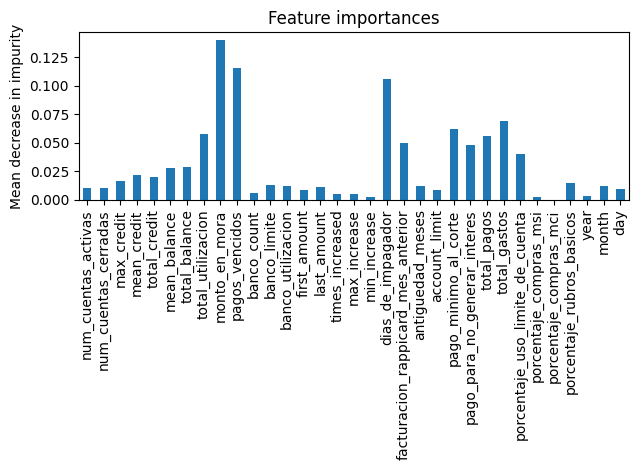

In [ ]:
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Las tres variables con mayor importancia en la probabilidad de default son monto en mora, días de impagador y pagos vencidos. Las tres están muy relacionadas pero cada una en distintas dimensiones.


*   Monto en mora se refiere al monto total que el cliente debe en sus cuentas de acuerdo al Buró de Crédito, por lo que a mayor dinero que un cliente deba a bancos, mayor debe ser su probabilidad de no poder pagarlo.
*   Días de impagador está altamente relacionado a la probabilidad de default dado que independientemente del valor de impago, más tiempo sin pagar se traduce después de determinado tiempo en un default.
*   El número de pagos vencidos se relaciona con la probabilidad de default al tener el cliente un historial previo de impago existe mayor posibilidad de que esto vuelva a ocurrir.





# Pregunta 3

Al obtener y verificar el accuracy del modelo, se puede revisar que este este bien calibrado de acuerdo a lo observado. Para esto se generó un set de validación aislado de los efectos de entrenamiento y también del testing. Este set de validación contiene 20% de las observaciones (40,000 cuentas), por lo  que se puede dividir en cinco bins de 8,000 cuentas en las que se puede comparar la probabilidad observada en cada una contra la predicha por el modelo.

In [ ]:
#Se empieza por aleatorizar el set de validacion
#(uniendo X, y para hacerlo en menos pasos)

X_val['impago'] = y_val

X_val.sample(frac = 1).reset_index(drop=True)

bins = np.array_split(X_val, 5)

In [ ]:
#Iterar sobre los bins para obtener las metricas de evaluacion de
#desempeño del modelo

proba_obs =[]
proba_pred = []
acc = []
f1 = []
recall = []
prec = []



for bin in bins:

  y_bin = bin.impago
  X_bin = bin.drop('impago', axis = 1)

  obs = y_bin.sum()/8000

  proba_obs.append(obs)

  y_pred = best.predict(X_bin)
  pred = y_pred.sum()/8000

  proba_pred.append(pred)

  acc.append(accuracy_score(y_bin, y_pred))
  f1.append(f1_score(y_bin, y_pred))
  recall.append(recall_score(y_bin, y_pred))
  prec.append(precision_score(y_bin, y_pred))


metrics_df = pd.DataFrame({'y_obs': proba_obs,
                           'y_pred':proba_pred,
                           'accuracy': acc,
                           'f1_score': f1,
                           'recall': recall,
                           'precision': prec})


In [ ]:
metrics_df

,y_obs,y_pred,accuracy,f1_score,recall,precision
0,0.243750,0.257375,0.909625,0.819656,0.842564,0.797960
1,0.244375,0.263750,0.906875,0.816728,0.849105,0.786730
2,0.243500,0.262875,0.907625,0.817576,0.850103,0.787447
3,0.252500,0.267000,0.904250,0.815688,0.839109,0.793539
4,0.240125,0.260125,0.901750,0.803598,0.837064,0.772705


Se observa que la predicción de impago y la observada son muy similares, siendo ligeramente más alta la predicha. Sin embargo, la precision y recall son bajos a pesar del accuracy elevado. Esto significa que la muestra imbalanceada no está siendo suficientemente corregida por el modelo y se podrían considerar algunas mejoras. Para el grupo de impago (1), parece estar prediciendo correctamente cerca alrededor del 84% de los casos en los cinco bins, por lo que esta predicción es aceptable, mientras que para el grupo no de impago(0), se predice correctamente alrededor del 78%. Esto es un buen inicio ya que es importante poder predecir con mejor seguridad aquellos que podrían presentar impago. También, dados los valores de precision y recall, existe una posibilidad de mejorar el modelo a través de probar ya sea otros modelos o intentar otros métodos para balancear la muestra.

# Pregunta 4

Para analizar efectos de cambios en las líneas de crédito, se necesita un modelo más interpretable como lo es la regresión logística. En este caso dado que todas las variables son numéricas, al estandarizarlas se pueden interpretar los coeficientes de manera directa en la probabilidad de impago. Para este modelo de igual manera se genera un GridSearchCV para encontrar los mejores hiperparámetros y se compara su accuracy con el modelo anterior. Más adelante se extraen los coeficientes para todas las variables y se ordenan en un DataFrame.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 16)

mod = LogisticRegression()

pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                 ('scaler', StandardScaler()),
                 ('model', mod)])

params = {'model__C': [0.1, 1, 10, 100], 'model__solver': ['liblinear']}

gs_lr = GridSearchCV(pipe, param_grid = params, cv = 5, scoring='f1')
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__solver': ['liblinear']},
             scoring='accuracy')

In [ ]:
y_pred = gs_lr.predict(X_test)
accuracy_score(y_pred, y_test)

0.91785

In [ ]:
best_mod = gs_lr.best_estimator_
best_mod.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=100, solver='liblinear'))])

In [ ]:
#Se obtienen los coeficientes del modelo con mejor desempeño
log_reg_model = best_mod.named_steps['model']
coefficients = log_reg_model.coef_
#coefficients

In [ ]:
coefficients_with_names = list(zip(X.columns, coefficients[0]))

In [ ]:
coefs= pd.DataFrame(coefficients_with_names, columns = ['feature', 'coefficient'])
coefs.sort_values(by ='coefficient')

,feature,coefficient
4,total_credit,-1.726771
21,account_limit,-0.527557
13,first_amount,-0.505187
14,last_amount,-0.485101
10,banco_count,-0.269462
15,times_increased,-0.247149
30,year,-0.247114
26,porcentaje_uso_limite_de_cuenta,-0.209948
3,mean_credit,-0.159252
7,total_utilizacion,-0.159075


De acuerdo a los coeficientes del modelo de Regresión Logística y debido a la estandarización de todos los campos de la base, un aumento en una desviación estándar -la cual es de $2361- de la línea de crédito aumentará en aproximadamente 1% la probabilidad de impago. Esto es muy similar para el incremento máximo y mínimo según los coeficientes mostrados por el modelo.

Para elaborar una estrategia de incremento de crédito que minimice el riesgo de impago, sería necesario fijarse en otras variables del modelo que actúen en dirección contraria al incremento de probabilidad de impago. Al explorar la magnitud y signo de los coeficientes, se observa que la variable de crédito total en Buró de Crédito va en dirección opuesta a la probabilidad de impago, esto tiene sentido ya que un cliente con altos niveles de crédito necesita comprobar un ingreso que pueda pagarlos. De igual manera, el límite de crédito en RappiCard y el monto de las líneas de crédito en RappiCard funcionan como reflejo de la situación financiera de los clientes.
Las cuatro variables consideradas anteriormente pueden ayudar a elaborar la estrategia de asignación de incrementos de crédito, al reflejar características deseables de clientes que tienen baja probabilidad de caer en impago pueden ser consideradas para filtrar y determinar clientes que sean candidatos a un aumento en su línea de crédito. Para lograr esto, un buen inicio sería tomar los resultados de este modelo como base e ingresar los datos del cliente respecto a las variables mencionadas anteriormente en la fórmula extendida de regresión logística para ver su probabilidad de impago, obteniendo así una probabilidad de impago dadas las características guardadas del cliente. Con esto, se podría determinar un límite inferior de probabilidad de impago y determinar los clientes a los que se podría ofrecer el incremento.

In [ ]:
df.max_increase.std()

2361.7612814167287

#Pregunta 5

Con los insights obtenidos en las preguntas previas, para determinar a qué clientes brindarles un aumento en su línea de crédito empezaría por utilizar los modelos creados para calcular su probabilidad de impago dadas todas sus características. Un VotingClassifier podría ser una opción para utilizar ambos modelos y agregaría algún modelo de boosting para tener un número impar de modelos.

Teniendo la predicción de impago de acuerdo al modelo de votación, buscaría a aquellos clientes por encima de cierto límite para determinar el grupo candidato a aumentos.
Este límite de probabilidad de impago habría que ser consultado con información histórica para determinar cuál es el nivel de riesgo que se quiere asumir en conjunto con otros objetivos de RappiCard de manera que en conjunto puedan minimizar el riesgo y maximizando las ganancias.

#Pregunta 6

Existen múltiples formas de determinar el monto de aumento de créditos dado que ya se conoce la probabilidad de impago de este grupo, tanto predicha como observada. Además, se asume que los clientes se van a seguir comportando como se comportaron previamente.

En este caso se podría empezar por preguntar cuál es la ganancia que se busca obtener al aumentar estas líneas de crédito en función del crédito total y el porcentaje de utilización.

Se empieza por determinar cuál es la ganancia sobre el monto de utilización. Esta se calcula determinando el nivel de ganancia que se obtiene del monto utilizado de créditos, que es el límite de crédito actual de cada cliente multiplicado por su porcentaje de utilización de crédito. De esta manera se obtiene el monto real que están pagando los clientes con su tarjeta y la ganancia que obtiene la empresa de ese gasto.

Obtenido el monto utilizado de crédito por cliente, se puede obtener el monto utilizado total como la suma de los montos de los clientes y por lo tanto el nivel de ganancia obtenido de éste (de datos financieros de la empresa si es que no es un porcentaje fijo si no es un porcentaje fijo por cliente).

Obtenidas estas cifras se puede calcular cuánto tendría que incrementar el crédito para obtener la ganancia objetivo, pero se tiene que tomar en cuenta la probabilidad de impago en este grupo que se minimizó pero sigue siendo mayor a cero. Para compensar este riesgo de impago, se divide por la probabilidad de no impago, aumentando ligeramente el monto de crédito, pero si todo lo demás se mantiene igual compensaría las pérdidas por impago.

La diferencia entre el monto utilizado total original y el nuevo calculado se puede determinar como el nivel de crédito por asignar para todo el grupo de clientes. Al tener clientes con distintos niveles de crédito y características de riesgo no se puede asigar a todos el mismo aumento, por lo que se puede buscar aumentar el crédito de manera proporcional a su monto de crédito actual ya sea con algún tipo de pesos para no asignar demasiado a aquellos con créditos muy grandes ni muy poco a aquellos con créditos pequeños.
